In [1]:
# Many fantastic pieces of free and open-source software can be used as key components to enable single cell analysis
# using python notebook. This scripts showed how to import scanpy result into single cell explorer. The analytic code parts
# are modified from scanpy tutorial "Clustering 3K PBMCs", the re-implemntation of Seurat’s (Satija et al., 2015)
# guided clustering tutorial. We gratefully acknowledge all authors for Suerat and Scanpy and their contribution.       
# we use 10K healthy donor's PBMCs data obtained from 10x Genomics 

#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_v3/pbmc_10k_v3_filtered_feature_bc_matrix.tar.gz -O data/pbmc_10k_v3_filtered_feature_bc_matrix.tar.gz
#!cd data; tar -xzf pbmc_10k_v3_filtered_feature_bc_matrix.tar.gz

In [5]:
import scpipeline

In [3]:
# other libs
import os, sys, csv,json,datetime,time,math,scipy.stats,collections,re;
from sklearn import preprocessing;
import numpy as np;
import pandas as pd;
import os.path;
import scanpy;
import scanpy.api as sc
sc.settings.set_figure_params(dpi=80)


In [6]:
### 
p =  scpipeline.ProcessPipline();
dataPath='./data/filtered_feature_bc_matrix/';  # the directory with the `.mtx` file
p.readData(dataPath)                            # read 10X '.mtx'data, compute mitochondra fraction, and create p.data 
p.data                                          # p.data: data object       

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
filtered out 10502 genes that are detected in less than 1 cells


AnnData object with n_obs × n_vars = 11769 × 23036 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

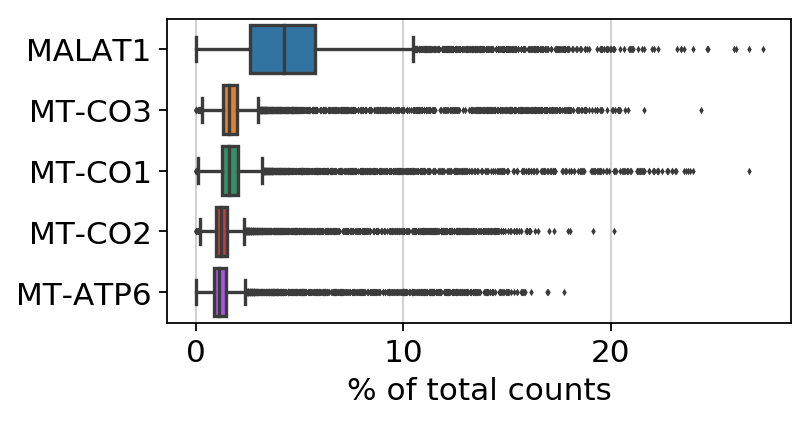

In [7]:
### p.data is the data object for use 
sc.pl.highest_expr_genes(p.data, n_top=5)

In [8]:
# QC function
# def QC(self,max_n_genes="" ,min_n_genes="",min_n_cells="",max_percent_mito="")
# scanpy tutorial QC(self,max_n_genes=2500 ,min_n_genes=200,min_n_cells=3,max_percent_mito=0.05)

p.QC(min_n_genes=200,min_n_cells=3)


filter cells
filtered out 232 cells that have less than 200 genes expressed
filter genes
filtered out 2684 genes that are detected in less than 3 counts


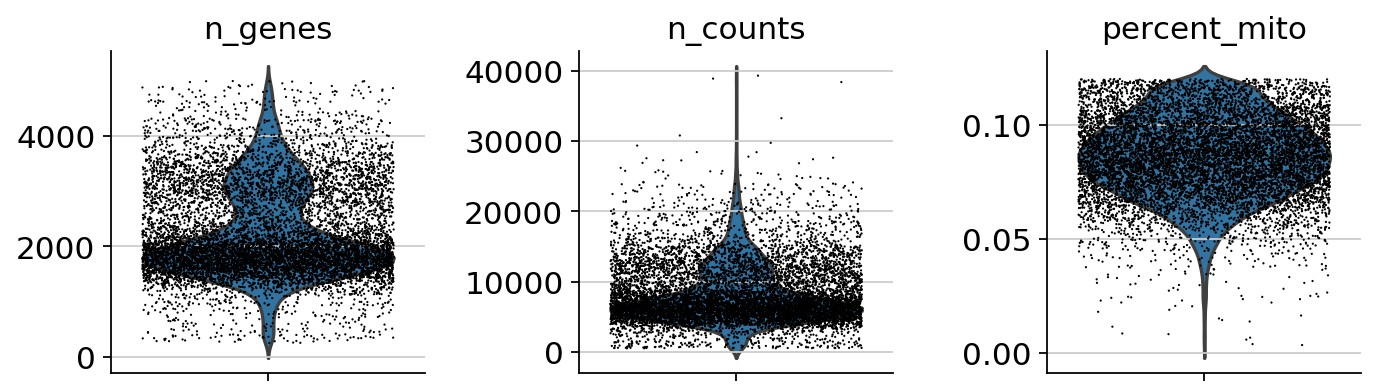

In [13]:
## plot percentage of mitochondria 
sc.pl.violin(p.data, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

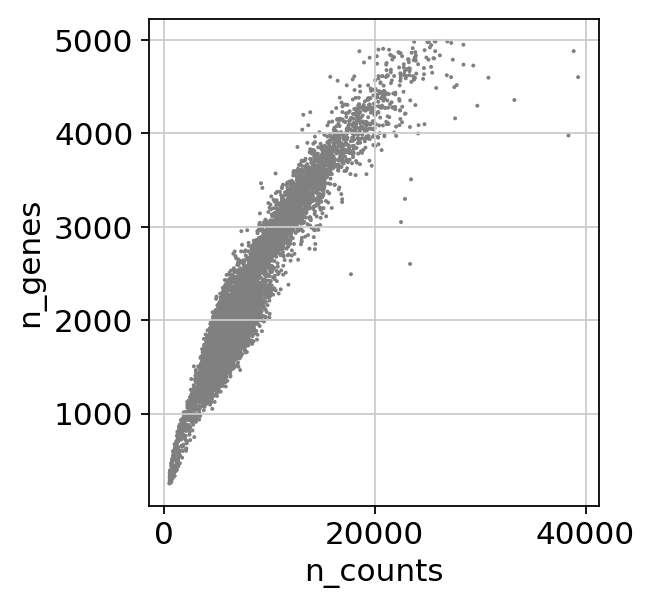

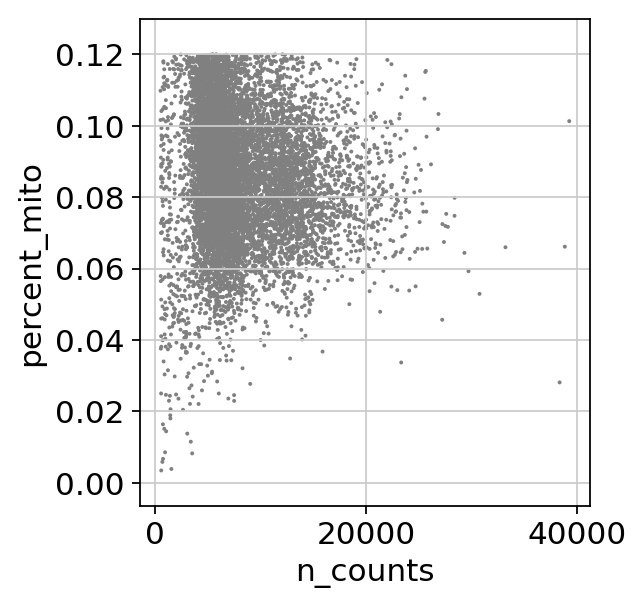

In [14]:
sc.pl.scatter(p.data, x='n_counts', y='n_genes')
sc.pl.scatter(p.data, x='n_counts', y='percent_mito')

In [15]:
# QC using percentage of mitochondria gene
p.QC(max_n_genes=5000, max_percent_mito=0.12)

"""
# for those who are more famaliar with scanpy: 
p.data = p.data[p.data.obs['n_genes'] < 5000, :]
p.data = p.data[p.data.obs['percent_mito'] < 0.12, :]
"""


filter n_genes < 5000
filter percent_mito < 0.12


"\n# for those who are more famaliar with scanpy: \np.data = p.data[p.data.obs['n_genes'] < 5000, :]\np.data = p.data[p.data.obs['percent_mito'] < 0.12, :]\n"

In [16]:
# QC in scanpy will remove cell barcodes. However, for database loading, adata should keep same number of barcodes as original one. 
# We copy data from p.data to adata, which will be used for loading to database   

adata = p.data.copy()

In [17]:
adata

AnnData object with n_obs × n_vars = 9571 × 20352 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'n_counts'

In [18]:
# normalization (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [19]:
#Logarithmize the data
sc.pp.log1p(adata)

In [20]:
adata.raw = adata

In [21]:
# highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


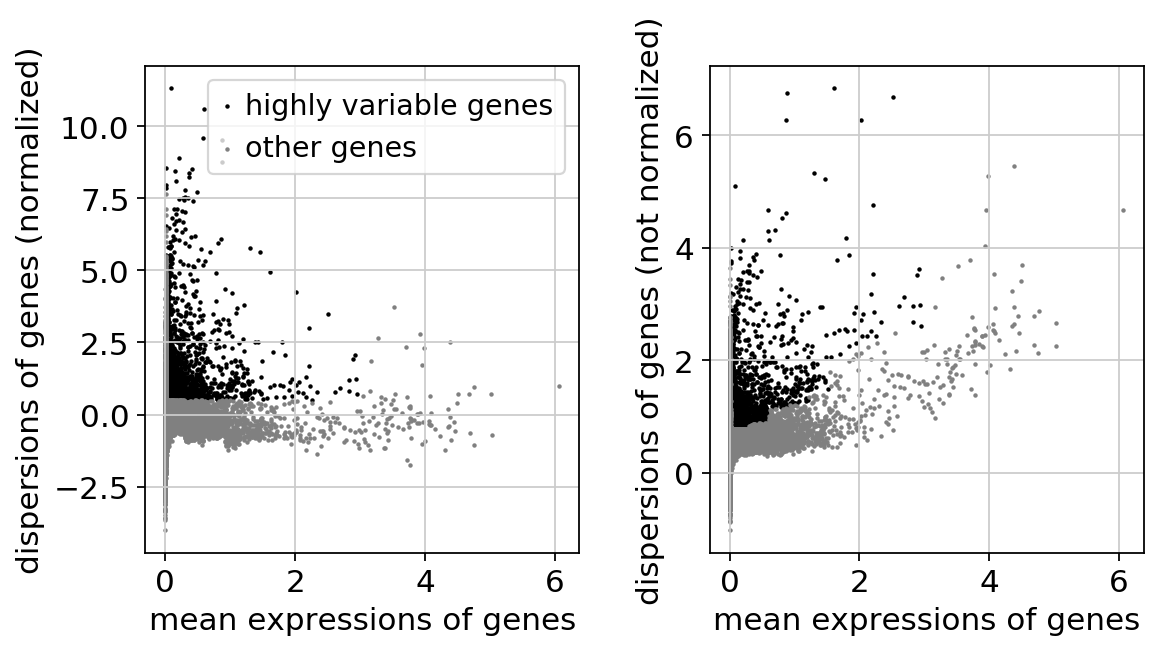

In [22]:
sc.pl.highly_variable_genes(adata)

In [22]:
adata = adata[:, adata.var['highly_variable']]
# regress out effects of total counts per cell and the percentage of mitochondrial genes.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:22.31)


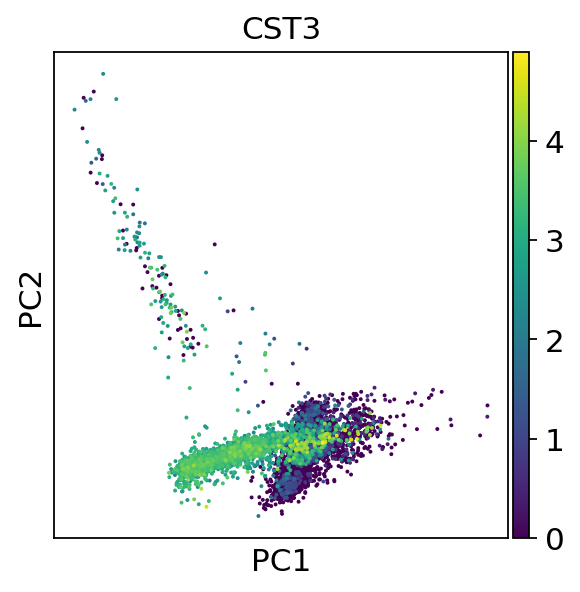

In [23]:
# Dimention reduction: PCA as a first step
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

In [24]:
adata

AnnData object with n_obs × n_vars = 9571 × 2049 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

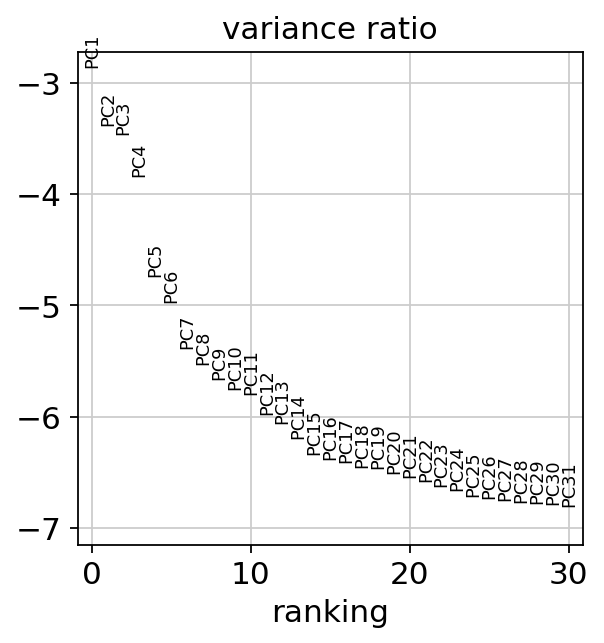

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:13.18) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [27]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:21.19) --> added
    'X_umap', UMAP coordinates (adata.obsm)


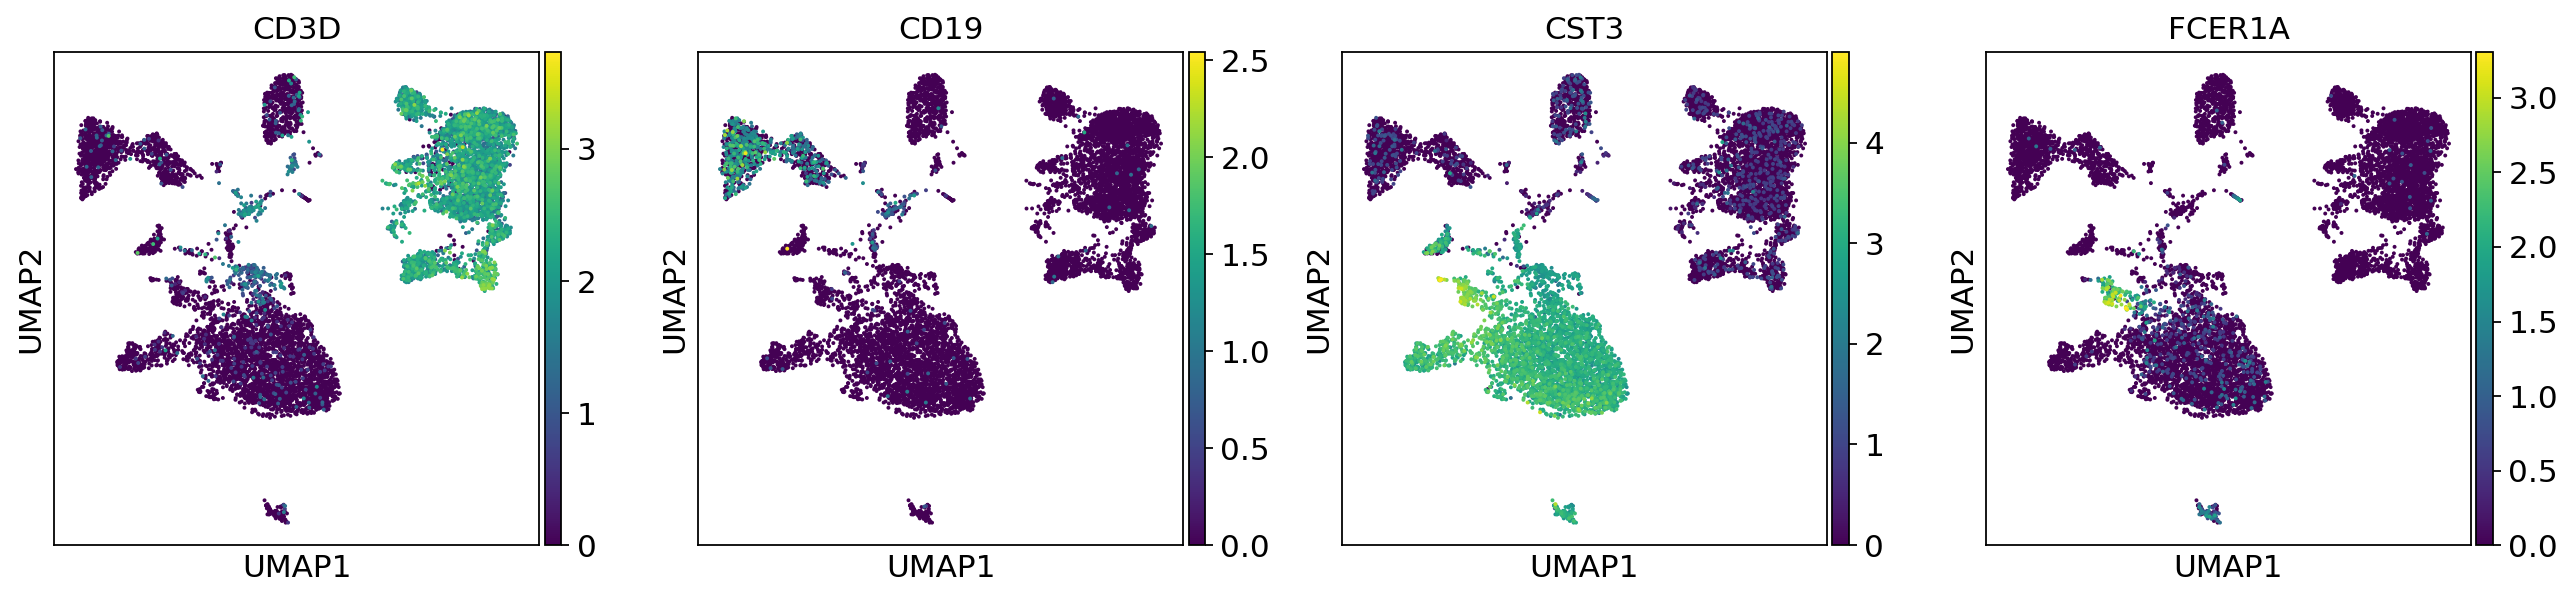

In [29]:
#sc.pl.umap(adata, color=['CD3D', 'NKG7', 'PPBP','IRF7','CD79A','CD14','FCGR3A','CLEC9A',"MS4A1", "GNLY", 'FCER1A',"CD8A"])
sc.pl.umap(adata, color=['CD3D','CD19', 'CST3', 'FCER1A'])

In [30]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:01.32) --> found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


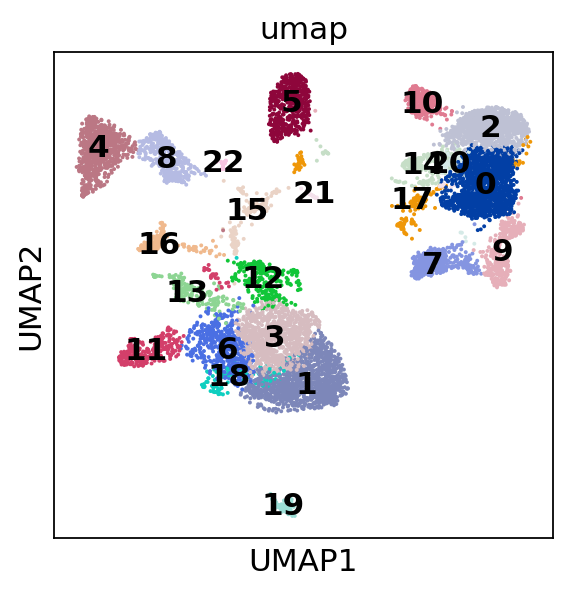

In [31]:
sc.pl.umap(adata, color=['leiden'],legend_loc='on data',title= "umap")

In [32]:
## optional marker gene identification
# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:01:29.12) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


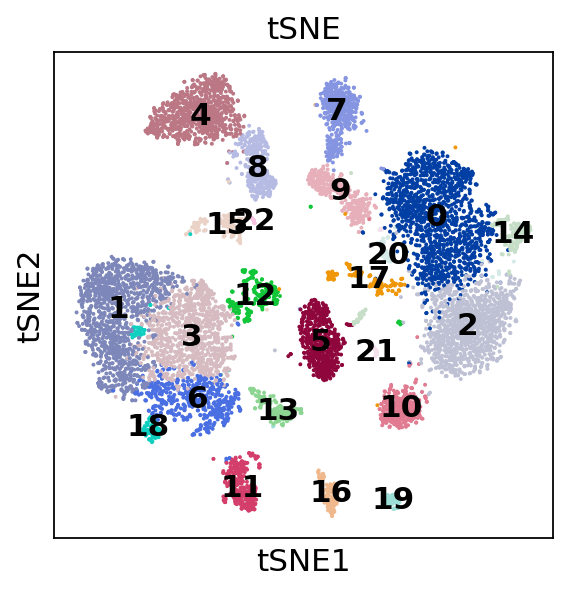

In [34]:
### t-SNE has better seperation among cell clusters, easy for single cell explorer users to lasso select cell clusters  
sc.tl.tsne(adata,n_pcs=40)
sc.pl.tsne(adata, color='leiden', legend_loc='on data', title='tSNE')

In [39]:
## data loading into single cell explorer database
p.insertToDB(dbname= 'singleCellDB',dbport= 27017,dbhost='localhost',
                   adata=adata,mapType="umap",    # umap, tsne 
                   mapName='pmbc10k_health_umap', # this is the title of the map, you can label details info 
                   study="Demo",
                   subjectid="",
                   disease="Healthy",
                   source="10XGenomic",
                   sample="Blood",
                   comment="",
                   author=""
              );

normalize....
start insert to db
success
mapid: 5ccf0a998f76ceaf39722b68


In [ ]:
## data loading into single cell explorer database
p.insertToDB(dbname= 'singleCellDB',dbport= 27017,dbhost='localhost',
                   adata=adata,mapType="tsne",
                   mapName='pmbc10k_health_tSNE', # this is the title of the map, you can label details info 
                   study="Demo",
                   subjectid="",
                   disease="Healthy",
                   source="10XGenomic",
                   sample="Blood",
                   comment="",
                   author=""
              );